Pairs Trade Trial Run

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sb
import matplotlib.pyplot as plt
import yfinance as yf
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(3, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

In [2]:
# Collect initial data in pairs
XOM_data = yf.Ticker("XOM").history(interval="1d",period='max',actions=True,repair=True)
SHEL_data = yf.Ticker("SHEL").history(interval="1d",period='max',actions=True,repair=True)

In [3]:
XOM_data.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Repaired?
Date,,,,,,,,
1962-01-02 00:00:00-05:00,0.0,0.094836,0.094137,0.094137,902400,0.0,0.0,False
1962-01-03 00:00:00-05:00,0.0,0.095535,0.094137,0.095535,1200000,0.0,0.0,False
1962-01-04 00:00:00-05:00,0.0,0.096234,0.095302,0.095768,1088000,0.0,0.0,False
1962-01-05 00:00:00-05:00,0.0,0.096234,0.093438,0.093671,1222400,0.0,0.0,False
1962-01-08 00:00:00-05:00,0.0,0.094370,0.092273,0.093438,1388800,0.0,0.0,False


          Close     Close
Close  1.000000  0.968047
Close  0.968047  1.000000


<Axes: xlabel='Date', ylabel='Close'>

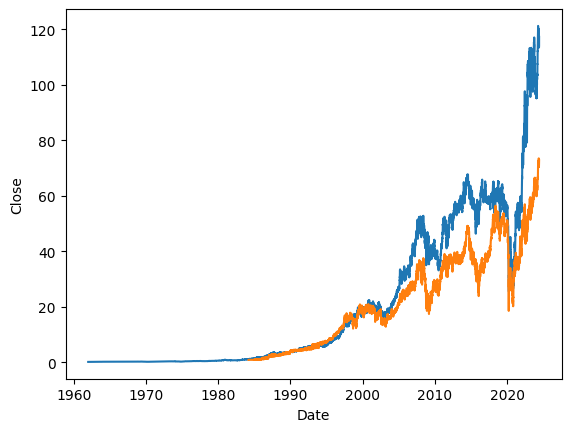

In [4]:
jointprice = pd.concat([XOM_data['Close'], SHEL_data['Close']], axis=1)
corr = jointprice.corr()
print(corr)

sb.lineplot(data = XOM_data,y = 'Close',x = XOM_data.index, errorbar=None)
sb.lineplot(data = SHEL_data,y = 'Close',x = SHEL_data.index,errorbar=None)

In [5]:
jointprice.columns = ['XOM_close','SHEL_close']
jointprice.dropna(axis=0,how='any',inplace=True)
jointprice.head(5)
# price extracted from yfinance is adjusted close: already accounting stock splits, dividends, capital gain distributions

,XOM_close,SHEL_close
Date,,
1984-03-12 00:00:00-05:00,1.114164,0.805693
1984-03-13 00:00:00-05:00,1.093009,0.805693
1984-03-14 00:00:00-05:00,1.078906,0.805693
1984-03-15 00:00:00-05:00,1.093009,0.805693
1984-03-16 00:00:00-05:00,1.100061,0.805693


Intercept of Regression 	: b =  [0.08363785]
Coefficients of Regression 	: a =  [[1.0525199]]



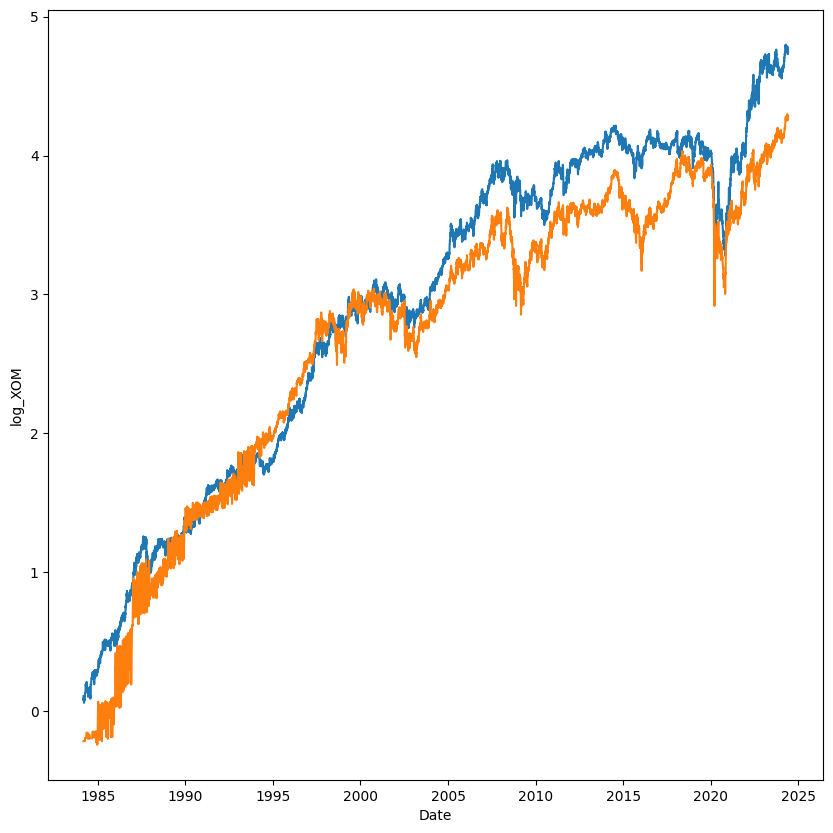

In [10]:
# Determine variables and conducted regression to find spread
jointprice['log_XOM'] = np.log(jointprice['XOM_close'])
jointprice['log_SHEL'] = np.log(jointprice['SHEL_close'])

f = plt.figure(figsize=(10,10))
sb.lineplot(data = jointprice, y = 'log_XOM', x = jointprice.index,errorbar=None)
sb.lineplot(data = jointprice, y = 'log_SHEL', x = jointprice.index, errorbar=None)

# Regress XOM against SHEL
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

""" # Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(jointprice['log_SHEL']),pd.DataFrame(jointprice['log_XOM']), test_size = 0.25,random_state=42) """

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(pd.DataFrame(jointprice['log_SHEL']), pd.DataFrame(jointprice['log_XOM']))        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_) # premium
print('Coefficients of Regression \t: a = ', linreg.coef_) # hedge ratio
print()

<Axes: xlabel='Date', ylabel='spread'>

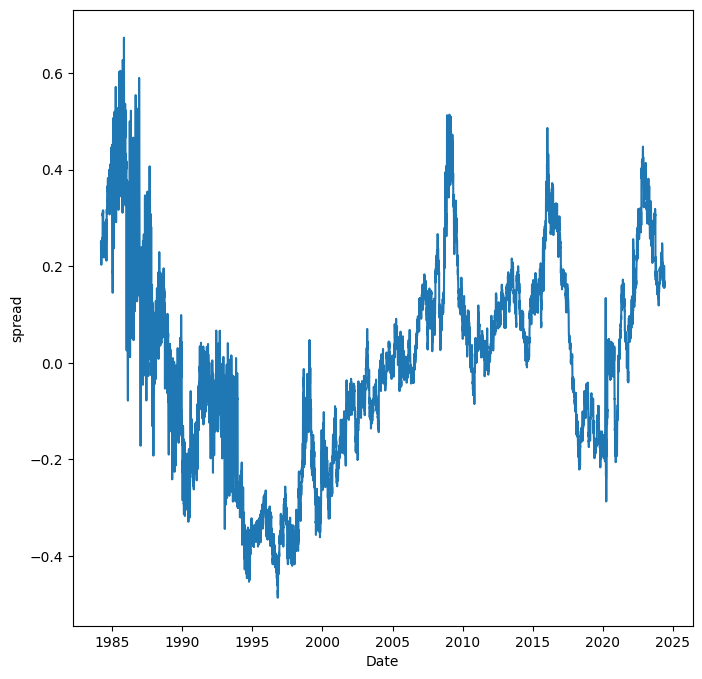

In [12]:
# We define the spread as Xt = log(Y) - (a + b* log(X))
jointprice['spread'] = jointprice['log_XOM'] - (0.08363785 + 1.0525199*jointprice['log_SHEL'])

f1 = plt.figure(figsize=(8,8))
sb.lineplot(data=jointprice, y = 'spread',x = jointprice.index,errorbar=None)